In [582]:
import pandas as pd
import pickle
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, fftpack, stats, signal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
import os
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import defaultdict

# Module to interpolate values.
def interpolate_missing_vals(i, identifier):
    s1 = []
    store_val = []
    x = 0
    if identifier == 'meal':
        for elems in meal_df.iloc[i]:
            s1.append(elems)
    else:
        for elems in no_meal_df.iloc[i]:
            s1.append(elems)        
    
    data = {'vals' : s1}
    df = pd.DataFrame(data = data)

    # Interpolate the values.
    #df['vals'].interpolate(method = 'polynomial', order = 3, inplace = True)
    df['vals'].interpolate(method = 'pad', limit = 2, inplace = True)
    store_val = list(df['vals'])
    
    if identifier == 'meal':
        for cols in meal_df.columns:
            meal_df.at[i, cols] = store_val[x]
            x += 1
    else:
        for cols in no_meal_df.columns:
            no_meal_df.at[i, cols] = store_val[x]
            x += 1

# Module to perform polynomial fit
# to get the coefficient values.
def perform_polyfit(i):
    colmns = ['coeff_0', 'coeff_1', 'coeff_2']
    co_eff = []
    itr = 0
    vals = list(new_training.iloc[i])
    interval = [j * 5 for j in range(0, len(new_training.iloc[i]))]
    p_fit = list(np.polyfit(interval, vals, 2))
    co_eff.extend(p_fit)
    # Plot chart
    # Uncomment the below lines to
    # plot the curve.
    #plt.plot(p_fit)
    #plt.show()
    for cols in colmns:
        feature_df.at[i, cols] = co_eff[itr]
        itr += 1

# Module to perform fft.
def perform_fft(i):
    itr = 0
    vals = list(new_training.iloc[i])
    fft_plot = abs(fftpack.fft(vals))
    fft_vals = sorted(set(fft_plot), reverse = True)
    feature_df.at[i, 'high_1'] = fft_vals[1]
    feature_df.at[i, 'high_2'] = fft_vals[2]
    feature_df.at[i, 'high_3'] = fft_vals[3]
    # Plot chart
    # Uncomment the below lines to
    # plot the curve.
    #print('FFT', [fft_vals[1], fft_vals[2], fft_vals[2]])
    #plt.plot(fft_vals[1:])
    #plt.show()

# Module to perform CGM velocity method.
def cgm_velocity(i):
    window_size = 3
    time_line = 15
    velocity = []
    val_store = new_training.iloc[i]
    for j in range(0, len(new_training.iloc[i]) - window_size):
        interim = (val_store[j] - val_store[j + window_size]) / time_line
        velocity.append(interim)
    # Find standard deviation of the series.
    s_dev = pd.Series(velocity).std()
    mean_val = pd.Series(velocity).mean()
    median_val = pd.Series(velocity).median()
    feature_df.at[i, 'cgm_velocity_stdv'] = s_dev
    feature_df.at[i, 'cgm_velocity_mean'] = mean_val
    feature_df.at[i, 'cgm_velocity_median'] = median_val
    #plt.plot(velocity)
    #plt.show()

# Module to perform Welch method.
def perform_welch(i):
    store_interim = new_training.iloc[i]
    hz, welch_values  = np.array((signal.welch(store_interim)))
    welch_std = pd.Series(welch_values).std()
    welch_mean = pd.Series(welch_values).mean()
    welch_median = pd.Series(welch_values).median()
    feature_df.at[i, 'max_welch'] = max(welch_values)
    feature_df.at[i, 'std_welch'] = welch_std
    feature_df.at[i, 'mean_welch'] = welch_mean
    feature_df.at[i, 'median_welch'] = welch_median
    #plt.plot(hz, welch_values)
    #plt.show()

# Module to perform PCA.
def performPCA():
    pc_features = feature_df.columns
    feature_matrix = feature_df.loc[:, pc_features].values
    # Normalize the feature values.
    feature_matrix = StandardScaler().fit_transform(feature_matrix)
    pca_cons = PCA(n_components = 10)
    principal_components = pca_cons.fit_transform(feature_matrix)
    final_component = pd.DataFrame(data = principal_components, 
                                   columns = ['component_1', 'component_2', 
                                              'component_3', 'component_4', 
                                              'component_5', 'component_6', 
                                              'component_7', 'component_8', 
                                              'component_9', 'component_10'])
    pca_var = pca_cons.explained_variance_ratio_
    pc_comps = (abs(pca_cons.components_))
    #print(abs(pca_cons.components_))
    pca_var = ['{:f}'.format(item) for item in pca_var]
    #print(pca_var)
    return final_component    
    
def db_scan():
    m = DBSCAN(eps = 1.9, min_samples = 4,algorithm = 'ball_tree', metric='minkowski', leaf_size=90, p=2)
    m.fit(final_df)
    clusters = m.labels_
    #colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
    #vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    #plt.scatter(final_df.loc[:,'component_1'], final_df.loc[:,'component_2'], c=vectorizer(clusters))
    # Add the cluster columns.
    db_scan_df['clust'] = clusters
    
    #print(db_scan_df.groupby(['clust']).count())
    
    # Get the number of cluster from
    # dbscan.
    n_clusts = len(np.unique(clusters))
    un_clusts = np.unique(clusters)
    
    # Get the count of elements in each
    # cluster
    a = db_scan_df.groupby(['clust']).count()
    
    # Ignore the outlier value.
    store_counts = a.loc[0:,'component_1']

    # Store the cluster ids with maximum
    # density.
    re_clusts = []
    re_clusts.append(-1)
    mx_val = max(store_counts)
    for i in range(0, len(store_counts)):
        if store_counts[i] == mx_val:
            re_clusts.append(i)

    # Create new dataframe with max val
    # cluster.
    max_clust_df = pd.DataFrame(columns = db_scan_df.columns)
    for i in range(0, len(db_scan_df)):
        # Extract the clusters with maximum frequency.
        if db_scan_df['clust'][i] in re_clusts:
            max_clust_df.loc[i] = db_scan_df.loc[i]

    # K in kmeans based on clusters
    # found in dbscan
    rem  = n_clusts - len(re_clusts)
    k_mns = 6 - rem
    itr = 6 - rem

    # change cluster names.
    good_clusts = list(set(un_clusts) ^ set (re_clusts))
    for clts in good_clusts:
        for i in range(0, len(db_scan_df['clust'])):
            if db_scan_df['clust'][i] == clts:
                db_scan_df['clust'][i] = itr
        itr += 1

    # Perform K means.
    kmeans = KMeans(n_clusters = k_mns, init = 'k-means++', max_iter = 1000, n_init = 10, random_state = 0)
    pred_y = kmeans.fit_predict(max_clust_df)

    # Update the db scan df after
    # kmeans.
    max_clust_df['clust'] = pred_y
    for idxs in max_clust_df.index:
        db_scan_df.loc[idxs] = max_clust_df.loc[idxs, 'component_1' : 'clust']
        
def perform_kmns():
    # Perform K means.
    kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 1000, n_init = 10, random_state = 0)
    k_mns_pred = kmeans.fit_predict(k_means_df)
    k_means_df['clust'] = k_mns_pred

def add_bins(loc_df):
    # Add bins
    for k in range(0, len(loc_df)):
        if loc_df['true_amt'][k] == 0:
            loc_df['bins'][k] = 'c_0' 
        elif loc_df['true_amt'][k] > 0 and loc_df['true_amt'][k] <= 20:
            loc_df['bins'][k] = 'c_0_20'
        elif loc_df['true_amt'][k] > 20 and loc_df['true_amt'][k] <= 40:
            loc_df['bins'][k] = 'c_20_40'
        elif loc_df['true_amt'][k] > 40 and loc_df['true_amt'][k] <= 60:
            loc_df['bins'][k] = 'c_40_60' 
        elif loc_df['true_amt'][k] > 60 and loc_df['true_amt'][k] <= 80:
            loc_df['bins'][k] = 'c_60_80'
        else:
            loc_df['bins'][k] = 'c_80_100'
    return loc_df

def add_new_truth(new_loc_df):
    # Find the grouped counts.
    d_interim = new_loc_df.groupby(['clust', 'bins']).count()

    storage_dict = defaultdict(list)
    itr = 0

    # Create the dictionary to store
    # the counts and clusters.
    while itr <= 6 - 1:
        for i in range(0, len(d_interim['component_1'][itr].index)):
            t = (d_interim['component_1'][itr].index[i], d_interim['component_1'][itr][i])
            storage_dict[itr].append(t)
        itr += 1

    truth_bins = ['c_0', 'c_0_20', 'c_20_40', 'c_40_60', 'c_60_80', 'c_80_100']
    truth_clusts = [0, 1, 2, 3, 4, 5] 
    count_vals = list(d_interim['component_1'])

    # Form the id list.
    idx_lst = []
    idx_cust = []
    for elems in list(d_interim['component_1'].index):
        idx_lst.append(elems[1])
        idx_cust.append(elems[0])

    assigned_bin = {}
    del_bin = 'na'
    del_clust = 9999
    iter_loop = 1

    # Iterate for all the clusters
    while iter_loop <= 6:
        flag = 0
        mx_count_val = int(max(count_vals))
    
        for key, vals in storage_dict.items():
            for a, b in vals:
                # Assign cluster to bin.
                if b == mx_count_val:
                    del_bin = a
                    truth_bins.remove(del_bin)
                
                    del_clust = key
                    truth_clusts.remove(del_clust)
                
                    assigned_bin[a] = key
                    # Remove the assigned cluster
                    # from the storage dict.
                    storage_dict.pop(key)
                    flag = 1
                    break
            if flag == 1:
                break
            
        # Remove the popped bin
        print('Remove bin', del_bin)
        #truth_bins.remove(del_bin)
        print('remove key', del_clust)
        #truth_clusts.remove(del_clust)
    
        for key, vals in storage_dict.items():
            for a, b in vals:
                if a == del_bin:
                    vals.remove((a,b))
        iter_loop += 1
        
        # Remove the current max
        for i in range(0, len(idx_lst)):
            if idx_lst[i] == del_bin or idx_cust[i] == del_clust:
                count_vals[i] = -1111

    # Assign the unassigned values.
    if len(truth_bins) != 0:
        for item in range(0, len(truth_bins)):
            assigned_bin[truth_bins[item]] = truth_clusts[item]


    # Add the new bins to the dataframe.
    new_loc_df['new_bins'] = 'na'

    # Assign the new bins to the dataframe.
    for i in range(0, len(new_loc_df)):
        for key, val in assigned_bin.items():
            if int(new_loc_df['clust'][i]) == val:
                new_loc_df['new_bins'][i] = key    
    
    return new_loc_df

if __name__ == '__main__':
        
    # Module to read all the csv files
    col_names = []
    for i in range(1, 32):
        col_name_val = 'c' + str(i)
        col_names.append(col_name_val)
    
    #col_names.append('class')
    # Read the meal data
    meal1 = pd.read_csv('Dataset/mealData1.csv', names = col_names)
    meal2 = pd.read_csv('Dataset/mealData2.csv', names = col_names)
    meal3 = pd.read_csv('Dataset/mealData3.csv', names = col_names)
    meal4 = pd.read_csv('Dataset/mealData4.csv', names = col_names)
    meal5 = pd.read_csv('Dataset/mealData5.csv', names = col_names)
    meal_df = pd.concat([meal1, meal2, meal3, meal4, meal5], ignore_index = True)
    
    # Read the meal amount data.
    meal_amt1 = pd.read_csv('Dataset/mealAmountData1.csv', names = ['Meal_Amount'])
    meal_amt2 = pd.read_csv('Dataset/mealAmountData2.csv', names = ['Meal_Amount'])
    meal_amt3 = pd.read_csv('Dataset/mealAmountData3.csv', names = ['Meal_Amount'])
    meal_amt4 = pd.read_csv('Dataset/mealAmountData4.csv', names = ['Meal_Amount'])
    meal_amt5 = pd.read_csv('Dataset/mealAmountData5.csv', names = ['Meal_Amount'])
    
    # Concat the cluster values
    amount_df = pd.concat([meal_amt1[0 : 51], meal_amt2[0 : 51], meal_amt3[0 : 51], meal_amt4[0 : 51], meal_amt5[0 : 51]], ignore_index = True)
    meal_df['clust'] = amount_df
    
    # Create the feature data frame.
    feature_df = pd.DataFrame(columns = ['coeff_0', 'coeff_1', 'coeff_2', 'high_1', 'high_2', 'high_3', 'cgm_velocity_stdv', 'cgm_velocity_mean', 'cgm_velocity_median', 'max_welch', 'std_welch', 'mean_welch', 'median_welch'])
    # Interpolate the missing values in
    # meal data.
    for i in range(len(meal_df)):
        interpolate_missing_vals(i, 'meal')
    
    # Remove all NA values from the dataframe
    meal_df = meal_df.dropna()
    
    # Add Features
    new_training = meal_df.loc[:, 'c1' : 'c31'].copy()

    # Perform Polyfit
    for i in range(0, len(new_training)):
        perform_polyfit(i)

    # Perform polyfit feature
    for i in range(0, len(new_training)):
        perform_fft(i)
    
    # Perform CGM velocity feature
    for i in range(0, len(new_training)):
        cgm_velocity(i)
    
    # Perform welch feature
    for i in range(0, len(new_training)):
        perform_welch(i)
    
    # Perform PCA
    final_df = performPCA()
    
    db_scan_df = final_df.copy()
    k_means_df = final_df.copy()
    
    # Perform dbscan
    db_scan()
    
    # Perform kmeans
    perform_kmns()
    
    # Add ground truth
    db_scan_df['true_amt'] = amount_df
    db_scan_df['bins'] = 'NA'
    # Add ground truth
    k_means_df['true_amt'] = amount_df
    k_means_df['bins'] = 'NA'
    
    db_scan_df = add_bins(db_scan_df)
    k_means_df = add_bins(k_means_df)
    
    # Add new truth labels.
    db_scan_df = add_new_truth(db_scan_df)
    k_means_df = add_new_truth(k_means_df)

/usr/local/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 31, using nperseg = 31
  .format(nperseg, input_length))


Remove bin c_0
remove key 1
Remove bin c_40_60
remove key 5
Remove bin c_0_20
remove key 2
Remove bin c_20_40
remove key 0
Remove bin c_60_80
remove key 3
Remove bin c_60_80
remove key 3
Remove bin c_0
remove key 1
Remove bin c_40_60
remove key 5
Remove bin c_0_20
remove key 3
Remove bin c_20_40
remove key 0
Remove bin c_20_40
remove key 0
Remove bin c_20_40
remove key 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:216: SettingWithCopyWarning: 
A value is trying to 

In [583]:
cntr = 0
for i in range(0, len(db_scan_df)):
    if db_scan_df['bins'][i] == db_scan_df['new_bins'][i]:
        cntr += 1
print(cntr)
print(cntr/len(db_scan_df))

50
0.22624434389140272


In [584]:
cntr = 0
for i in range(0, len(k_means_df)):
    if k_means_df['bins'][i] == k_means_df['new_bins'][i]:
        cntr += 1
print(cntr)
print(cntr/len(k_means_df))

57
0.2579185520361991


       component_1  component_2  component_3  component_4  component_5  \
clust                                                                    
-1              37           37           37           37           37   
 0             184          184          184          184          184   

       component_6  component_7  component_8  component_9  component_10  
clust                                                                    
-1              37           37           37           37            37  
 0             184          184          184          184           184  


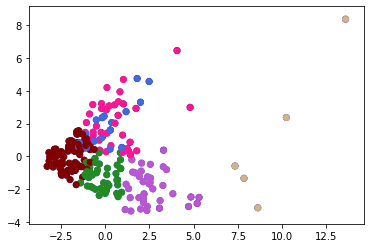

In [561]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

m = DBSCAN(eps = 1.9, min_samples = 4,algorithm = 'ball_tree', metric='minkowski', leaf_size=90, p=2)
m.fit(final_df)
clusters = m.labels_
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(final_df.loc[:,'component_1'], final_df.loc[:,'component_2'], c=vectorizer(clusters))

db_scan_df = final_df.copy()
db_scan_df['clust'] = clusters
print(db_scan_df.groupby(['clust']).count())
# Get the number of cluster from
# dbscan.
n_clusts = len(np.unique(clusters))
un_clusts = np.unique(clusters)
# Get the count of elements in each
# cluster
a = db_scan_df.groupby(['clust']).count()
# Ignore the outlier value.
store_counts = a.loc[0:,'component_1']

# Store the cluster ids with maximum
# density.
re_clusts = []
re_clusts.append(-1)
mx_val = max(store_counts)
for i in range(0, len(store_counts)):
    if store_counts[i] == mx_val:
        re_clusts.append(i)

# Create new dataframe with max val
# cluster.
max_clust_df = pd.DataFrame(columns = db_scan_df.columns)
for i in range(0, len(db_scan_df)):
    # Extract the clusters with maximum frequency.
    if db_scan_df['clust'][i] in re_clusts:
        max_clust_df.loc[i] = db_scan_df.loc[i]

# K in kmeans based on clusters
# found in dbscan
rem  = n_clusts - len(re_clusts)
k_mns = 6 - rem
itr = 6 - rem
# change cluster names.
good_clusts = list(set(un_clusts) ^ set (re_clusts))
for clts in good_clusts:
    for i in range(0, len(db_scan_df['clust'])):
        if db_scan_df['clust'][i] == clts:
            db_scan_df['clust'][i] = itr
    itr += 1

# Perform K means.
kmeans = KMeans(n_clusters = k_mns, init = 'k-means++', max_iter = 1000, n_init = 10, random_state = 0)
pred_y = kmeans.fit_predict(max_clust_df)

# Update the db scan df after
# kmeans.
max_clust_df['clust'] = pred_y
for idxs in max_clust_df.index:
    db_scan_df.loc[idxs] = max_clust_df.loc[idxs, 'component_1' : 'clust']

# Plot scatter plot
cls = np.array(db_scan_df['clust'])
cls = cls.astype(int)
plt.scatter(db_scan_df.loc[:,'component_1'], db_scan_df.loc[:,'component_2'], c=vectorizer(cls))

In [562]:
from collections import defaultdict

# Add ground truth
db_scan_df['true_amt'] = amount_df
db_scan_df['bins'] = 'NA'

# Add bins
for k in range(0, len(db_scan_df)):
    if db_scan_df['true_amt'][k] == 0:
        db_scan_df['bins'][k] = 'c_0' 
    elif db_scan_df['true_amt'][k] > 0 and db_scan_df['true_amt'][k] <= 20:
        db_scan_df['bins'][k] = 'c_0_20'
    elif db_scan_df['true_amt'][k] > 20 and db_scan_df['true_amt'][k] <= 40:
        db_scan_df['bins'][k] = 'c_20_40'
    elif db_scan_df['true_amt'][k] > 40 and db_scan_df['true_amt'][k] <= 60:
        db_scan_df['bins'][k] = 'c_40_60' 
    elif db_scan_df['true_amt'][k] > 60 and db_scan_df['true_amt'][k] <= 80:
        db_scan_df['bins'][k] = 'c_60_80'
    else:
        db_scan_df['bins'][k] = 'c_80_100'

# Find the grouped counts.
d_interim = db_scan_df.groupby(['clust', 'bins']).count()

storage_dict = defaultdict(list)
itr = 0

# Create the dictionary to store
# the counts and clusters.
while itr <= 6 - 1:
    for i in range(0, len(d_interim['component_1'][itr].index)):
        t = (d_interim['component_1'][itr].index[i], d_interim['component_1'][itr][i])
        storage_dict[itr].append(t)
    itr += 1

truth_bins = ['c_0', 'c_0_20', 'c_20_40', 'c_40_60', 'c_60_80', 'c_80_100']
truth_clusts = [0, 1, 2, 3, 4, 5] 
count_vals = list(d_interim['component_1'])

# Form the id list.
idx_lst = []
idx_cust = []
for elems in list(d_interim['component_1'].index):
    idx_lst.append(elems[1])
    idx_cust.append(elems[0])

assigned_bin = {}
del_bin = 'na'
del_clust = 9999
iter_loop = 1

# Iterate for all the clusters
while iter_loop <= 6:
    flag = 0
    mx_count_val = int(max(count_vals))
    
    for key, vals in storage_dict.items():
        for a, b in vals:
            # Assign cluster to bin.
            if b == mx_count_val:
                del_bin = a
                truth_bins.remove(del_bin)
                
                del_clust = key
                truth_clusts.remove(del_clust)
                
                assigned_bin[a] = key
                # Remove the assigned cluster
                # from the storage dict.
                storage_dict.pop(key)
                flag = 1
                break
        if flag == 1:
            break
            
    # Remove the popped bin
    print('Remove bin', del_bin)
    #truth_bins.remove(del_bin)
    print('remove key', del_clust)
    #truth_clusts.remove(del_clust)
    
    for key, vals in storage_dict.items():
        for a, b in vals:
            if a == del_bin:
                vals.remove((a,b))
    iter_loop += 1
    
    # Remove the current max
    for i in range(0, len(idx_lst)):
        if idx_lst[i] == del_bin or idx_cust[i] == del_clust:
            count_vals[i] = -1111

# Assign the unassigned values.
if len(truth_bins) != 0:
    for item in range(0, len(truth_bins)):
        assigned_bin[truth_bins[item]] = truth_clusts[item]


# Add the new bins to the dataframe.
db_scan_df['new_bins'] = 'na'

# Assign the new bins to the dataframe.
for i in range(0, len(db_scan_df)):
    for key, val in assigned_bin.items():
        if int(db_scan_df['clust'][i]) == val:
            db_scan_df['new_bins'][i] = key


Remove bin c_0
remove key 1
Remove bin c_40_60
remove key 5
Remove bin c_0_20
remove key 2
Remove bin c_20_40
remove key 0
Remove bin c_60_80
remove key 3
Remove bin c_60_80
remove key 3


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning

In [563]:
cntr = 0
for i in range(0, len(db_scan_df)):
    if db_scan_df['bins'][i] == db_scan_df['new_bins'][i]:
        cntr += 1
print(cntr)
print(cntr/len(db_scan_df))

50
0.22624434389140272


In [564]:
k_means_df = final_df.copy()

In [565]:
# Perform K means.
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 1000, n_init = 10, random_state = 0)
k_mns_pred = kmeans.fit_predict(k_means_df)
k_means_df['clust'] = k_mns_pred

In [567]:
k_means_df['clust'] = k_mns_pred

In [569]:
# Add ground truth
k_means_df['true_amt'] = amount_df
k_means_df['bins'] = 'NA'

# Add bins
for k in range(0, len(k_means_df)):
    if k_means_df['true_amt'][k] == 0:
        k_means_df['bins'][k] = 'c_0' 
    elif k_means_df['true_amt'][k] > 0 and k_means_df['true_amt'][k] <= 20:
        k_means_df['bins'][k] = 'c_0_20'
    elif k_means_df['true_amt'][k] > 20 and k_means_df['true_amt'][k] <= 40:
        k_means_df['bins'][k] = 'c_20_40'
    elif k_means_df['true_amt'][k] > 40 and k_means_df['true_amt'][k] <= 60:
        k_means_df['bins'][k] = 'c_40_60' 
    elif k_means_df['true_amt'][k] > 60 and k_means_df['true_amt'][k] <= 80:
        k_means_df['bins'][k] = 'c_60_80'
    else:
        k_means_df['bins'][k] = 'c_80_100'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarn

In [571]:
# Find the grouped counts.
d_interim = k_means_df.groupby(['clust', 'bins']).count()

storage_dict = defaultdict(list)
itr = 0

# Create the dictionary to store
# the counts and clusters.
while itr <= 6 - 1:
    for i in range(0, len(d_interim['component_1'][itr].index)):
        t = (d_interim['component_1'][itr].index[i], d_interim['component_1'][itr][i])
        storage_dict[itr].append(t)
    itr += 1

truth_bins = ['c_0', 'c_0_20', 'c_20_40', 'c_40_60', 'c_60_80', 'c_80_100']
truth_clusts = [0, 1, 2, 3, 4, 5] 
count_vals = list(d_interim['component_1'])

# Form the id list.
idx_lst = []
idx_cust = []
for elems in list(d_interim['component_1'].index):
    idx_lst.append(elems[1])
    idx_cust.append(elems[0])

assigned_bin = {}
del_bin = 'na'
del_clust = 9999
iter_loop = 1

# Iterate for all the clusters
while iter_loop <= 6:
    flag = 0
    mx_count_val = int(max(count_vals))
    
    for key, vals in storage_dict.items():
        for a, b in vals:
            # Assign cluster to bin.
            if b == mx_count_val:
                del_bin = a
                truth_bins.remove(del_bin)
                
                del_clust = key
                truth_clusts.remove(del_clust)
                
                assigned_bin[a] = key
                # Remove the assigned cluster
                # from the storage dict.
                storage_dict.pop(key)
                flag = 1
                break
        if flag == 1:
            break
            
    # Remove the popped bin
    print('Remove bin', del_bin)
    #truth_bins.remove(del_bin)
    print('remove key', del_clust)
    #truth_clusts.remove(del_clust)
    
    for key, vals in storage_dict.items():
        for a, b in vals:
            if a == del_bin:
                vals.remove((a,b))
    iter_loop += 1
    
    # Remove the current max
    for i in range(0, len(idx_lst)):
        if idx_lst[i] == del_bin or idx_cust[i] == del_clust:
            count_vals[i] = -1111

# Assign the unassigned values.
if len(truth_bins) != 0:
    for item in range(0, len(truth_bins)):
        assigned_bin[truth_bins[item]] = truth_clusts[item]


# Add the new bins to the dataframe.
k_means_df['new_bins'] = 'na'

# Assign the new bins to the dataframe.
for i in range(0, len(k_means_df)):
    for key, val in assigned_bin.items():
        if int(k_means_df['clust'][i]) == val:
            k_means_df['new_bins'][i] = key

Remove bin c_0
remove key 1
Remove bin c_40_60
remove key 5
Remove bin c_0_20
remove key 3
Remove bin c_20_40
remove key 0
Remove bin c_20_40
remove key 0
Remove bin c_20_40
remove key 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [572]:
cntr = 0
for i in range(0, len(k_means_df)):
    if db_scan_df['bins'][i] == k_means_df['new_bins'][i]:
        cntr += 1
print(cntr)
print(cntr/len(k_means_df))

57
0.2579185520361991


In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(final_df)
distances, indices = nbrs.kneighbors(final_df)

In [6]:
distances

array([[ 0.        ,  0.94406059],
       [ 0.        ,  1.77486416],
       [ 0.        ,  0.72791112],
       [ 0.        ,  0.75506065],
       [ 0.        ,  0.76341216],
       [ 0.        ,  1.31662074],
       [ 0.        ,  0.91889741],
       [ 0.        ,  1.0981582 ],
       [ 0.        ,  0.81430786],
       [ 0.        ,  0.8889521 ],
       [ 0.        ,  2.47702364],
       [ 0.        ,  1.40554494],
       [ 0.        ,  1.08233877],
       [ 0.        ,  0.98059179],
       [ 0.        ,  1.12466992],
       [ 0.        ,  0.96632863],
       [ 0.        ,  0.58280662],
       [ 0.        ,  1.12520944],
       [ 0.        ,  0.86258663],
       [ 0.        ,  0.75506065],
       [ 0.        ,  0.97311545],
       [ 0.        ,  0.98059179],
       [ 0.        ,  1.17218719],
       [ 0.        ,  1.33972571],
       [ 0.        ,  0.69799692],
       [ 0.        ,  2.98582781],
       [ 0.        ,  1.78309153],
       [ 0.        ,  1.74594383],
       [ 0.        ,

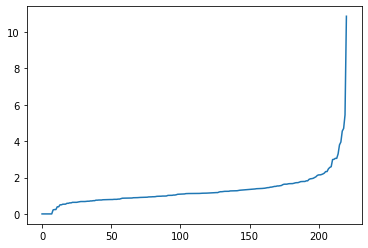

In [8]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)